## Read the data first

In [8]:
from pathlib import Path

import pandas as pd

df = pd.read_csv(Path('../../results/repository_evolution_0-4924_fixed_bug_MERGED.csv'))
df_commits = pd.read_csv(Path('../../data/huggingface_sort_by_createdAt_top996939_commits_0_1035.csv'))

# grabs the date from df2 and adds it to df based on commit_hash and repo_url matching, implementation needs to be efficient
def add_date_to_df(df, df_commits):
    df['date'] = ""
    for index, row in df.iterrows():
        commit_hash = row['commit_hash']
        repo_url = row['repo_url']
        matched_row = df_commits.loc[
            (df_commits['commit_hash'] == commit_hash) & 
            (df_commits['repo_url'] == repo_url)
        ]
        
        df.at[index, 'date'] = matched_row['date'].values[0]
        df.at[index, 'message'] = matched_row['message'].values[0]
    return df

df = add_date_to_df(df, df_commits)
df['date'] = pd.to_datetime(df['date'])

# Reference date when safetensors was released
reference_date = pd.to_datetime("2022-09-23")

# Calculate elapsed days since reference date
df['elapsed_days'] = (df['date'] - reference_date).dt.days
df

,repo_url,commit_hash,model_file_path,serialization_format,date,message,elapsed_days
0,sentence-transformers/all-MiniLM-L6-v2,3746fd5f4cfd46ae64fc781df53e7cbb7849eb62,sentence-transformers/all-MiniLM-L6-v2/tf_mode...,h5/hdf5,2022-06-15 17:28:20,Add TF weights,-100
1,sentence-transformers/all-MiniLM-L6-v2,2cfdf1ac2b3fc894d8239133174385c0baed9a17,sentence-transformers/all-MiniLM-L6-v2/pytorch...,torch.save,2021-08-30 15:05:43,up,-389
2,sentence-transformers/all-MiniLM-L6-v2,acbb28c8aa70f5503c85d6b90e8cd65606993a20,sentence-transformers/all-MiniLM-L6-v2/pytorch...,torch.save,2021-08-30 15:04:51,upload,-389
3,sentence-transformers/all-MiniLM-L6-v1,4ccf77db5049cc31b815180ea2d79ff4d4a1fccd,sentence-transformers/all-MiniLM-L6-v1/model.s...,safetensors,2024-03-27 05:40:56,Adding `safetensors` variant of this model (#3...,551
4,sentence-transformers/all-MiniLM-L6-v1,61e09b17912b00d11964d763292e1ea2058cf84c,sentence-transformers/all-MiniLM-L6-v1/pytorch...,torch.save,2021-08-18 07:15:03,upload,-401
...,...,...,...,...,...,...,...
7581,albert/albert-base-v1,66b3f3c279cf3a1df6d8df1cffa60d4d026ea396,albert/albert-base-v1/model.safetensors,safetensors,2023-04-06 09:42:57,Adding `safetensors` variant of this model (#1...,195
7582,albert/albert-base-v1,7b2207b0995b9618ed866befd087bee3673f022d,albert/albert-base-v1/tf_model.h5,h5/hdf5,2020-06-22 11:29:35,Update tf_model.h5,-823
7583,albert/albert-base-v1,88a9e47f102a579a457fe04451612a6689d20fee,albert/albert-base-v1/spiece.model,ONNX,2020-03-23 13:11:49,Update spiece.model,-914
7584,albert/albert-base-v1,c59a95f1bc8a34dcc72170f19416b12d1e34a260,albert/albert-base-v1/pytorch_model.bin,torch.save,2020-03-23 13:11:48,Update pytorch_model.bin,-914


## RQ1 How long it took developers to adopt safetensors after its first release?

Goal is to check when safetensors was first used in each studied repository.    

### Analysis 1: Number of elapsed days since the release of safetensors
Compute the number of model files added/changed over time since the release of safetensors.

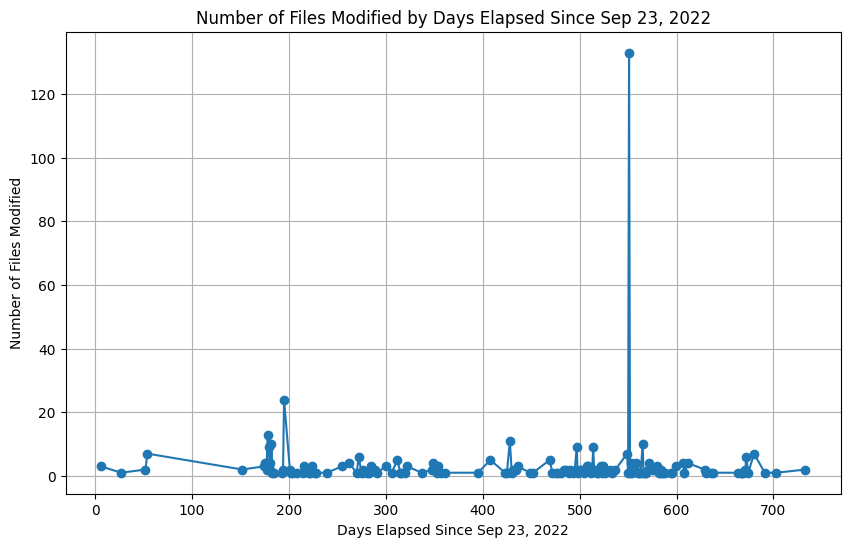

In [9]:
import matplotlib.pyplot as plt

# Filter out rows with 'safetensors' serialization format
df_safetensors = df[df['serialization_format'] == 'safetensors']

# Group by elapsed days to count files modified on each date
files_modified_by_day = df_safetensors['elapsed_days'].value_counts().sort_index()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(files_modified_by_day.index, files_modified_by_day.values, marker='o', linestyle='-')
plt.xlabel("Days Elapsed Since Sep 23, 2022")
plt.ylabel("Number of Files Modified")
plt.title("Number of Files Modified by Days Elapsed Since Sep 23, 2022")
plt.grid(True)
plt.show()


### Analysis 2: Number of elapsed days since safetensors first appearead in a repo


Number of analyzed repos:  1028
Number of repos without safetensors: 612
Number of repos using safe tensors 416
(min, quartile2, median, quartile4, max) (6, 224.0, 512.5, 551.0, 733)


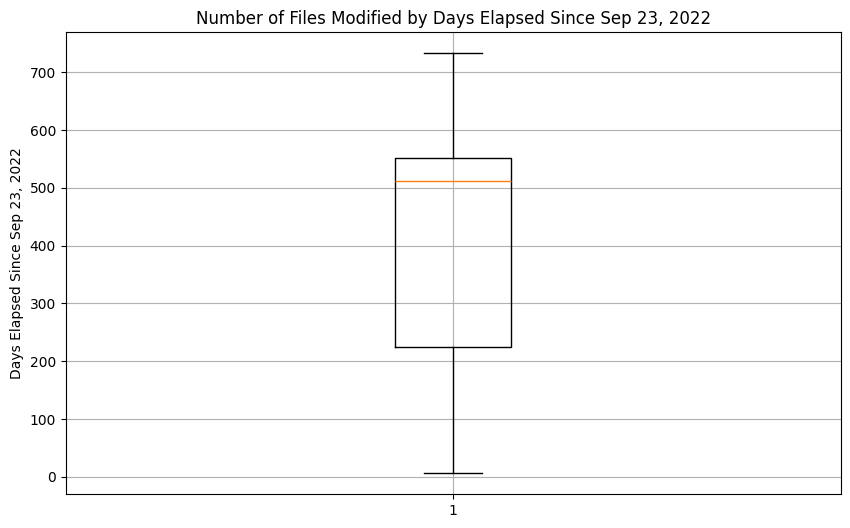

In [10]:
import matplotlib.pyplot as plt

# Filter out rows with 'safetensors' serialization format
df_safetensors = df[df['serialization_format'] == 'safetensors']


# find the lowest number of elapsed days per unique repo_url
df_safetensors_first_appearance = df_safetensors.groupby('repo_url')['elapsed_days'].min()
df_safetensors_first_appearance = df_safetensors_first_appearance.reset_index()

df_safetensors_first_appearance
min = df_safetensors_first_appearance['elapsed_days'].min()
max = df_safetensors_first_appearance['elapsed_days'].max()
median = df_safetensors_first_appearance['elapsed_days'].median()
quartile2 = df_safetensors_first_appearance['elapsed_days'].quantile(0.25)
quartile4 = df_safetensors_first_appearance['elapsed_days'].quantile(0.75)
# count number of repos wihout safetensors
print("Number of analyzed repos: ", len(df['repo_url'].unique()))
print(f"Number of repos without safetensors: {len(df['repo_url'].unique()) - len(df_safetensors_first_appearance)}")
print("Number of repos using safe tensors", len(df_safetensors_first_appearance))
print("(min, quartile2, median, quartile4, max)",(min, quartile2, median, quartile4, max))

# show box plot
plt.figure(figsize=(10, 6))
plt.boxplot(df_safetensors_first_appearance['elapsed_days'])
plt.ylabel("Days Elapsed Since Sep 23, 2022")
plt.title("Number of Files Modified by Days Elapsed Since Sep 23, 2022")
plt.grid(True)
plt.show()

TypeError: unhashable type: 'numpy.ndarray'

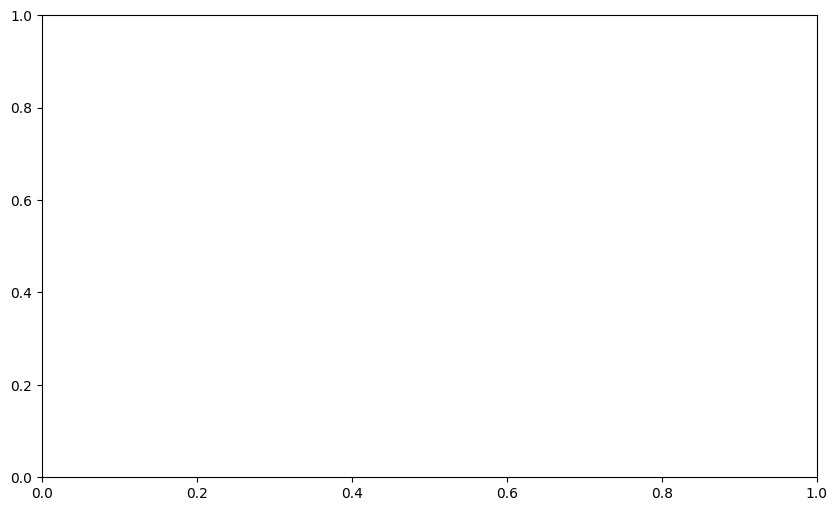

In [11]:
# plot files_modified_by_day
plt.figure(figsize=(10, 6))
plt.plot(df_safetensors_first_appearance.index, df_safetensors_first_appearance.values, marker='x', linestyle='-')
plt.xlabel("Days Elapsed Since Sep 23, 2022")
plt.ylabel("Number of Files Modified")
plt.title("Number of Files Modified by Days Elapsed Since Sep 23, 2022")
plt.grid(True)
plt.show()
